## RNN (Recurrent Neural network) - 순환 신경망: 시계열 데이터, 순차 데이터

DL은 3가지 기본 모델이 있다.
1. ANN
2. CNN
3. RNN (Recurrent Neural Network) 순환 신경망(시퀀스 데이터를 다루는 데 최적화) - 주가 / 문장 - 순서가 있는 데이터 

시계열 데이터를 처리하기 위해서 각 시점에서 입력을 받음.
각 시간단계에서 동일한 가중치를 공유하여, 시퀀스의 패턴을 학습한다.
순전파, 역전파(BPTT)를 통해 가중치를 학습한다.

RNN 오래 된 정보일수록 소실 된다. 소실은 최종 출력물에서 영향도를 보고 소실되어야 한다. 오래된 기억이 아니라, 쓸모없는 기억을 날려야 하는데 RNN의 구조는 오래된 문제를 소실시킨다. 

RNN은 장기 의존성 문제를 겪을 수 있다. 이를 해결하기 위해 LSTM과 GRU가 개발되었다. 

LSTM 셀(각 시점 정보의 흐름, 정보 유지) + 게이트(정보 선택적 저장/삭제)-> 새로운 정보를 셀에 얼마나 반영할지 결정
망각 gate가 있음
장점: 긴 시퀀스에서도 정보를 잘 저장함. 기울기 소실 문제가 완화됨
단점: 기능이 많아서 복잡함. 학습이 어려워서 오래걸림. 데이터 의존성이 좀 있음

GRU(Gated Recurrent Unit): LSTM의 변형으로, 셀 상태 대신 은닉 상태 만들 사용하여 구조를 단순화함
GRU는 업데이트 게이트(update gate)와 reset gate를 사용하여 정보를 조절함
셀 상태/ 숨겨진상태를 통합해서 단일 상태를 유지한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### 데이터 생성 및 전처리

In [2]:
# Sine 파형 데이터 생성
def create_sine_wave_data(seq_length, num_samples):
    X = []
    y = []
    for i in range(num_samples):
        start = np.random.rand()
        x = np.linspace(start, start + 2 * np.pi, seq_length)
        X.append(np.sin(x))
        y.append(np.sin(x + 0.1))
    return np.array(X), np.array(y)

seq_length = 50
num_samples = 1000

X, y = create_sine_wave_data(seq_length, num_samples)

# 데이터셋을 PyTorch 텐서로 변환
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape: [1000, 50, 1]
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # shape: [1000, 50, 1]

### 간단한 RNN 모델 정의

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)
        out = self.fc(out)  # 모든 시간 단계의 출력
        return out

# 모델 초기화
input_size = 1
hidden_size = 32
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

이렇게 배운 하나하나의 모듈을 레고 조립처럼 사용해서
큰 모델을 만든다. 

### 모델 학습

In [4]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X)  # shape: [1000, 50, 1]
    optimizer.zero_grad()
    loss = criterion(outputs, y)  # y를 직접 사용
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [10/100], Loss: 0.0093
Epoch [20/100], Loss: 0.0085
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0013
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0007
Epoch [100/100], Loss: 0.0006
Finished Training


In [5]:
print(outputs.shape)  # 모델의 출력 크기
print(y.shape)        # 타겟 데이터 크기

torch.Size([1000, 50, 1])
torch.Size([1000, 50, 1])


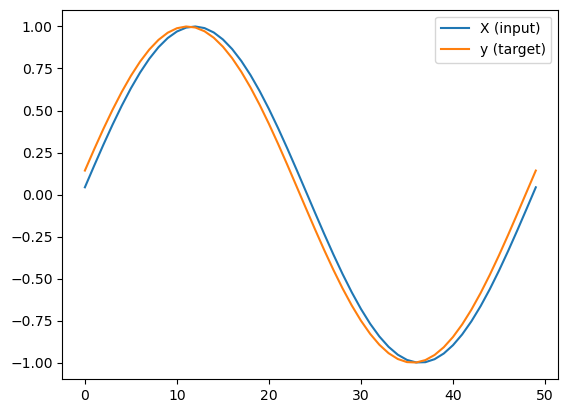

In [6]:
import matplotlib.pyplot as plt

# 데이터 시각화
plt.plot(X[0].squeeze(), label='X (input)')
plt.plot(y[0].squeeze(), label='y (target)')
plt.legend()
plt.show()

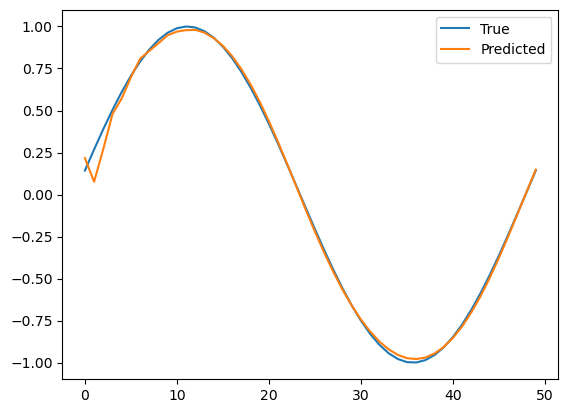

In [7]:
# 모델의 첫 번째 출력과 목표 값 시각화
with torch.no_grad():
    predicted = model(X).numpy()
    plt.plot(y[0].squeeze(), label='True')
    plt.plot(predicted[0].squeeze(), label='Predicted')
    plt.legend()
    plt.show()

In [ ]:
print(outputs.shape)  # 모델의 출력 크기
print(y.shape)        # 타겟 데이터 크기

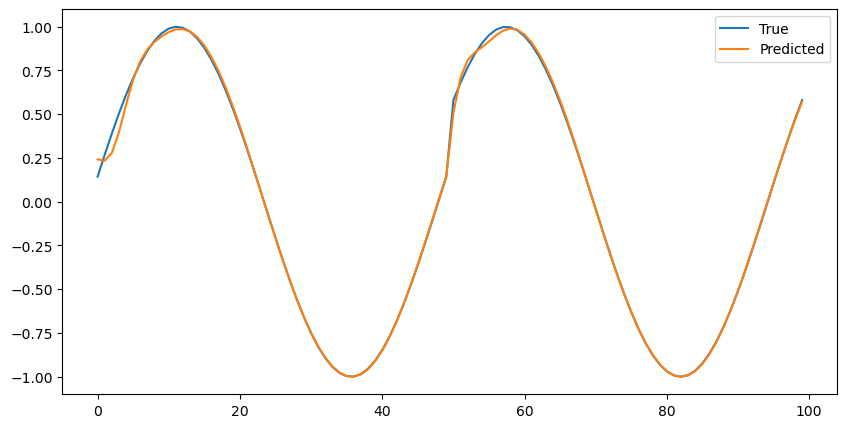

In [18]:
# 모델 평가
model.eval()
with torch.no_grad():
    predicted = model(X).detach().numpy()

# 시각화 #????이건 출력의 문제가 있음 
plt.figure(figsize=(10, 5))
plt.plot(y.numpy().flatten()[:100], label='True')
plt.plot(predicted.flatten()[:100], label='Predicted')
plt.legend()
plt.show()

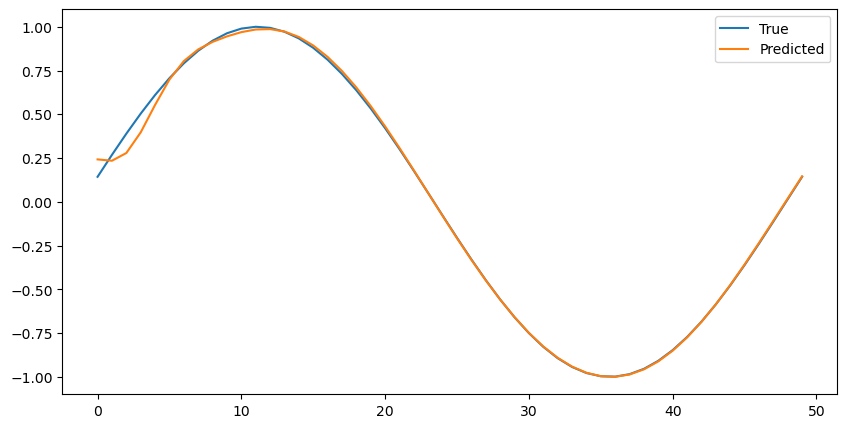

In [16]:
# 모델 평가
model.eval()
with torch.no_grad():
    predicted = model(X).detach().numpy()

# 시각화 (첫 번째 샘플만)
plt.figure(figsize=(10, 5))
plt.plot(y[0].numpy().flatten(), label='True')  # 첫 번째 샘플의 실제 값
plt.plot(predicted[0].flatten(), label='Predicted')  # 첫 번째 샘플의 예측 값
plt.legend()
plt.show()

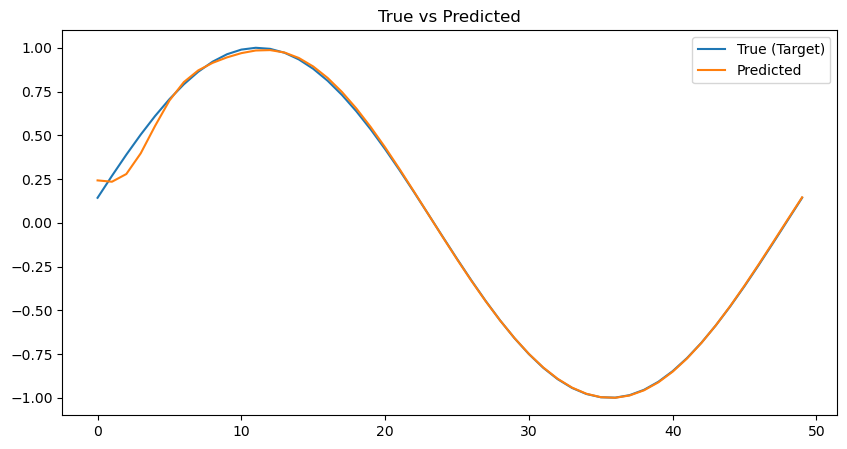

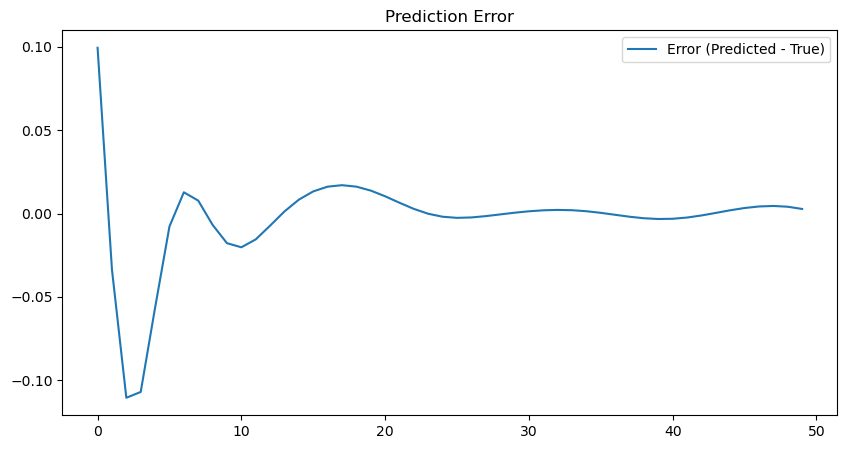

In [12]:
# 모델의 첫 번째 예측 값과 목표 값의 차이를 시각화
with torch.no_grad():
    predicted = model(X).numpy()  # 모델의 예측 값

    # 첫 번째 샘플의 실제 값과 예측 값을 플롯
    plt.figure(figsize=(10, 5))
    plt.plot(y[0].squeeze(), label='True (Target)')
    plt.plot(predicted[0].squeeze(), label='Predicted')
    plt.title('True vs Predicted')
    plt.legend()
    plt.show()

    # 첫 번째 샘플의 오차(예측 값 - 실제 값)를 시각화
    error = predicted[0].squeeze() - y[0].squeeze().numpy()
    plt.figure(figsize=(10, 5))
    plt.plot(error, label='Error (Predicted - True)')
    plt.title('Prediction Error')
    plt.legend()
    plt.show()


### 간단한 LSTM 모델 정의

In [9]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size)  # 초기 은닉 상태
        c0 = torch.zeros(1, x.size(0), hidden_size)  # 초기 셀 상태
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # 마지막 시간 단계의 출력 out 그대로 사용해야함 
        return out

model = SimpleLSTM(input_size, hidden_size, output_size)

In [10]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X)  # shape: [1000, 50, 1]
    optimizer.zero_grad()
    loss = criterion(outputs, y)  # y를 직접 사용
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [10/100], Loss: 0.1125
Epoch [20/100], Loss: 0.0088
Epoch [30/100], Loss: 0.0024
Epoch [40/100], Loss: 0.0018
Epoch [50/100], Loss: 0.0011
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0006
Finished Training


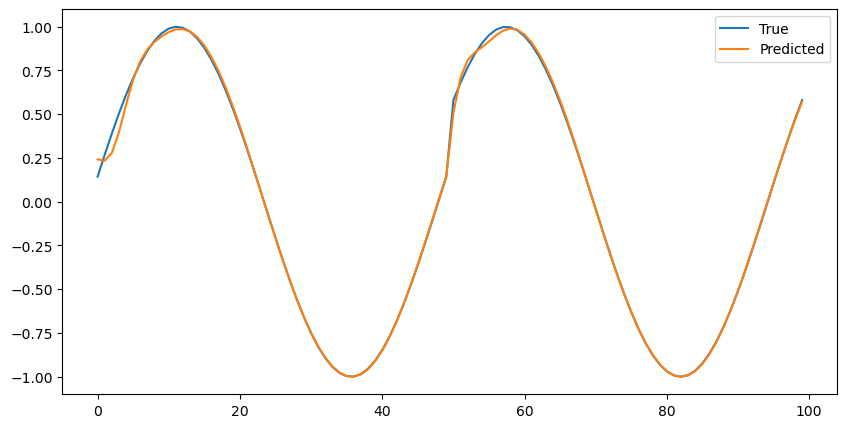

In [19]:
# 모델 평가
model.eval()
with torch.no_grad():
    predicted = model(X).detach().numpy()

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(y.numpy().flatten()[:100], label='True')
plt.plot(predicted.flatten()[:100], label='Predicted')
plt.legend()
plt.show()